In [1]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

# # keras
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# plt
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.5
Tensorflow   : 2.5.0


In [3]:
RANDOM_SEED = 42

In [4]:
train = pd.read_csv('ACT7_competition_training.csv')

In [5]:
train.sample(10)

,MOLECULE,Act,D_37,D_38,D_39,D_40,D_42,D_43,D_44,D_45,...,D_10739,D_10740,D_10741,D_10742,D_10744,D_10745,D_10746,D_10747,D_10764,D_10770
579,ACT7_M_95362,67.45,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83,ACT7_M_88531,10.60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,ACT7_M_91166,23.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364,ACT7_M_103653,84.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
686,ACT7_M_96456,56.98,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1457,ACT7_M_104494,75.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1311,ACT7_M_103031,76.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
402,ACT7_M_93355,72.49,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1397,ACT7_M_103980,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1257,ACT7_M_102489,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train.shape

(1569, 4507)

In [7]:
i = 0
delete_columns = []
for column in train.columns.to_list()[2:]:
    count = len(train[column].value_counts().values)
    if count == 1:
        i += 1
        delete_columns.append(column)
print(i)

133


In [8]:
# delete columns that do not provide any data
df = train.drop(delete_columns, axis=1)

In [9]:
df.shape

(1569, 4374)

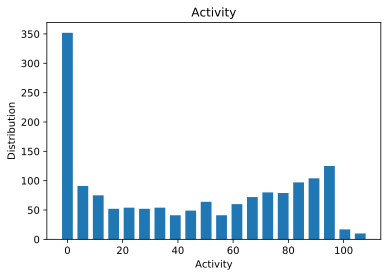

In [10]:
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_xlabel(title)
    ax.set_ylabel("Distribution")
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'Activity': df['Act'],
})


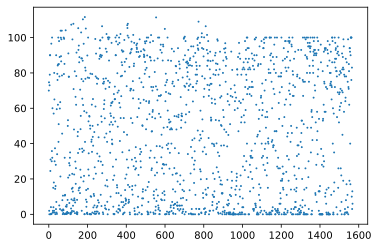

In [11]:
# The dataset contains many experiments with molecule activity equaled zero
plt.scatter(y=df['Act'], x=df.index, s=1)

In [12]:
df[df['Act']==0]

,MOLECULE,Act,D_37,D_38,D_39,D_40,D_42,D_43,D_44,D_45,...,D_10737,D_10738,D_10739,D_10741,D_10742,D_10744,D_10745,D_10746,D_10747,D_10764
3,ACT7_M_17594,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,ACT7_M_22161,0.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
217,ACT7_M_90975,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
304,ACT7_M_92083,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337,ACT7_M_92424,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,ACT7_M_104984,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1512,ACT7_M_105138,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1526,ACT7_M_105266,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1527,ACT7_M_105325,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# rescale features
for column in df.columns.to_list()[2:]:
    df[column] = np.log(df[column] + 1)

In [14]:
y = df['Act']     # target value
X = df.drop(['MOLECULE', 'Act'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

## Neural Network

In [18]:
def neural_network(input_shape=(128,)):

    model = models.Sequential()

    model.add(Dense(4000, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.25))

    model.add(Dense(2000, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.25))

    model.add(Dense(1000, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.25))

    model.add(Dense(1000, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.10))

    model.add(Dense(1, activation=None, use_bias=True, kernel_regularizer=l2(0.0001)))

    # model.summary()

    return model

In [19]:
optimizer = SGD(lr=0.05, momentum=0.9, clipnorm=1.0)
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)

C:\Users\ialsh\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
input_dim=X_train.shape[1]

In [21]:
model = neural_network((input_dim,))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4000)              17492000  
_________________________________________________________________
dropout (Dropout)            (None, 4000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              8002000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1

In [22]:
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [23]:
history = model.fit(X_train, np.log(y_train+1),
                    batch_size=128,
                    epochs=500, # or less if EarlyStopping brings to stop learning
                    validation_data=(X_test, np.log(y_test+1)),
                    callbacks=[earlystop],
                    verbose=0,
                   )

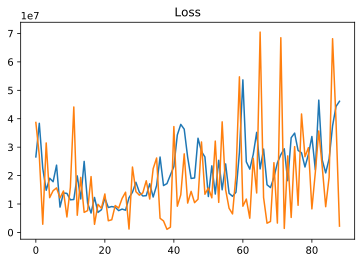

In [24]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [25]:
test_predict_nn = np.exp(model.predict(X_test))-1
print(f"TEST R2-score: {((r2_score(y_test, test_predict_nn[:,0])))}")

TEST R2-score: -1.833912302672195


In [26]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))
print(f"TEST mape: {(mape(y_test, test_predict_nn[:,0]))*100:0.2f}%")

TEST mape: inf%


In [27]:
# according to the formular provided
def r2_score_diff(y_true, y_pred):
    a = np.sum(np.array(y_true-np.mean(y_true))*(y_pred-np.mean(y_pred)))
    b = np.sum((np.array(y_true-np.mean(y_true)))**2)
    c = np.sum((y_pred-np.mean(y_pred))**2)
    return a*a/(b*c)
              
print(f"TEST R2: {r2_score_diff(y_test, test_predict_nn[:,0])}")                  

TEST R2: 0.08663542636943955


## RandomForest

In [28]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, np.log(y_train+1))
test_predict_rf = np.exp(rf.predict(X_test)) - 1

In [29]:
print(f"TEST R2-score: {((r2_score(y_test, test_predict_rf)))}")

TEST R2-score: 0.5604255027527006


In [30]:
print(f"TEST mape: {(mape(y_test, test_predict_rf))*100:0.2f}%")

TEST mape: inf%


In [31]:
print(f"TEST R2: {r2_score_diff(y_test, test_predict_rf)}")  

TEST R2: 0.6669510459288603


## CatBoostRegressor

In [75]:
from catboost import CatBoostRegressor

# Choosing the optimal depth

cbr_c = {'num_trees': [], 'mape_test': [], 'mape_train': []}

num_trees = [1, 2, 3, 4, 5]
for depth in num_trees:
    model_cbr = CatBoostRegressor(iterations=5000, random_seed=RANDOM_SEED, eval_metric='MAPE', custom_metric=['RMSE', 'MAE'],
                              silent=True, learning_rate=0.1, depth=depth)
    model_cbr.fit(X_train, np.log(y_train+1), eval_set=(X_test, np.log(y_test+1)),
              verbose_eval=0, use_best_model=True,)
    predict_test_cbr = np.exp(model_cbr.predict(X_test))-1
    predict_train_cbr = np.exp(model_cbr.predict(X_train))-1
    cbr_c['num_trees'].append(depth)
    cbr_c['mape_test'].append(round((mape(y_test, predict_test_cbr))*100, 2))
    cbr_c['mape_train'].append(round((mape(y_train, predict_train_cbr))*100, 2))
    
cbr_df = pd.DataFrame.from_dict(cbr_c)
cbr_df

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

,num_trees,mape_test,mape_train
0,1,11.52,6.91
1,2,11.36,5.18
2,3,11.13,3.98
3,4,11.18,4.59
4,5,11.05,4.43


In [16]:
# depth = 3
model_cbr = CatBoostRegressor(iterations=5000, random_seed=RANDOM_SEED, eval_metric='MAPE', custom_metric=['RMSE', 'MAE'],
                              silent=True, learning_rate=0.1, depth=3)
model_cbr.fit(X_train, np.log(y_train+1), eval_set=(X_test, np.log(y_test+1)), verbose_eval=0, use_best_model=True,)
test_predict_catboost = np.exp(model_cbr.predict(X_test))-1

In [17]:
print(f"TEST R2-score: {((r2_score(y_test, test_predict_catboost)))}")

TEST R2-score: 0.5514864878102466


In [21]:
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: inf%


In [24]:
print(f"TEST R2: {r2_score_diff(y_test, test_predict_catboost)}")  

TEST R2: 0.6114936658249625
